In [1]:
from jupyter_bbox_widget import BBoxWidget
import ipywidgets as widgets
import os
import json
import base64


# jupyter_bbox_widget

It's a custom widget that helps you annotate images for object detection tasks.

## Introduction

Initialize the widget with an image path and a list of classes.

Click and drag anywhere on the image to create bboxes, move and resize them as necessary.


In [22]:
widget = BBoxWidget(
    image='fruit/fruit.jpg',
    classes=['apple', 'orange', 'pear'],
)
widget

BBoxWidget(classes=['apple', 'orange', 'pear'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',…

Access the current state of bboxes like this:

In [4]:
widget.bboxes

[{'x': 375, 'y': 178, 'width': 179, 'height': 200, 'label': 'apple'},
 {'x': -40, 'y': -25, 'width': 174, 'height': 180, 'label': 'orange'},
 {'x': 41, 'y': 176, 'width': 231, 'height': 193, 'label': 'pear'}]

In [10]:
from matplotlib import pyplot as plt
from io import BytesIO

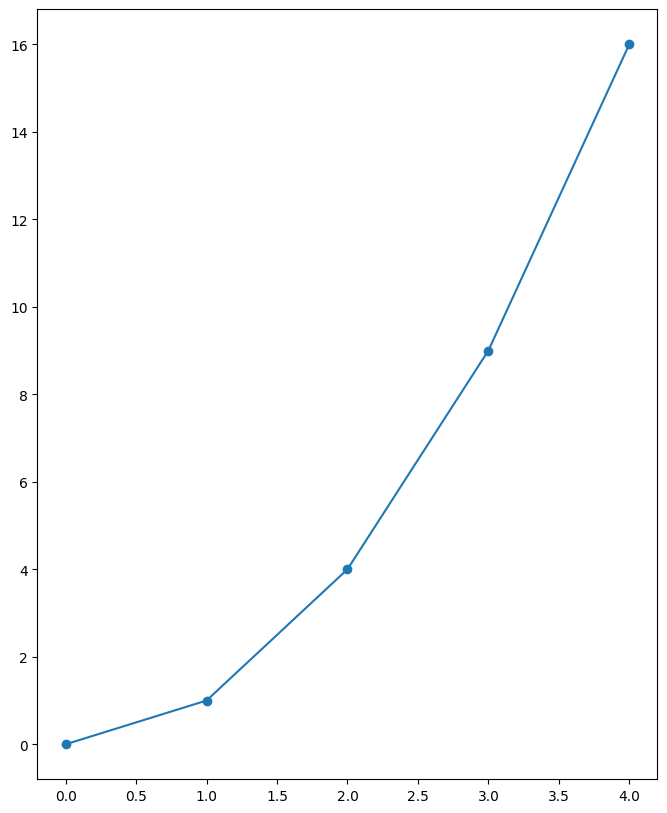

In [24]:
fig, ax = plt.subplots(figsize=(8,10))
ax.plot([0, 1, 2, 3, 4], [0, 1, 4, 9, 16], '-o')
bb = BytesIO()
fig.savefig(bb)
widget.image_bytes = bb.getvalue()

## Image display troubleshooting


The `image` property of the widget is used in its html as the image `src` attribute.

Images from the web are displayed nicely if you provide a URL. Jupyter Notebook can display images given a relative path to the image file. Jupyter Lab seems more strict about it and doesn't display the image this easily.

In order to display the image in Jupyter Lab you can encode it as a base64 string using this (or similar) function.

In [ ]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [ ]:
widget.image = encode_image('fruit/fruit2.jpg')
widget.bboxes = []

## A simple annotation workflow

Let's say we have a folder of image files that we would like to create annotations for.

In [ ]:
path = 'fruit'
files = sorted(os.listdir(path))

annotations = {}
annotations_path = 'annotations.json'

We'll use a `BBoxWidget` for creating annotations for an image. It already has "Submit" and "Skip" buttons for going through our list of images. Let's also add a progress bar - from the `ipywidgets` library.

In [ ]:
# a progress bar to show how far we got
w_progress = widgets.IntProgress(value=0, max=len(files), description='Progress')
# the bbox widget
w_bbox = BBoxWidget(
    image = encode_image(os.path.join(path, files[0])),
    classes=['apple', 'orange', 'pear']
)

# combine widgets into a container
w_container = widgets.VBox([
    w_progress,
    w_bbox,
])

Define the functions to process clicks on our Submit and Skip buttons.

You can use the widget's `on_skip` and `on_submit` methods as decorators on the functions.

In [ ]:
# when Skip button is pressed we move on to the next file
@w_bbox.on_skip
def skip():
    w_progress.value += 1
    # open new image in the widget
    image_file = files[w_progress.value]
    w_bbox.image = encode_image(os.path.join(path, image_file))
    # here we assign an empty list to bboxes but 
    # we could also run a detection model on the file
    # and use its output for creating inital bboxes
    w_bbox.bboxes = [] 

# when Submit button is pressed we save current annotations
# and then move on to the next file
@w_bbox.on_submit
def submit():
    image_file = files[w_progress.value]
    # save annotations for current image
    annotations[image_file] = w_bbox.bboxes
    with open(annotations_path, 'w') as f:
        json.dump(annotations, f, indent=4)
    # move on to the next file
    skip()

Or if you don't like the decorators syntax you can assign the functions manually like this:

In [ ]:
# w_bbox.on_skip(skip)
# w_bbox.on_submit(submit);

Now we display the container widget and we are ready to annotate.

In [ ]:
w_container

The last image has more fruit kinds than we anticipated, so we can just add more classes to the list and keep going:

In [ ]:
w_bbox.classes = w_bbox.classes + ['lemon', 'grapefruit']

To verify the saved annotations we can look at the annotations file contents:

In [ ]:
with open(annotations_path, 'r') as f:
    print(f.read())

## Recording additional data

Sometimes you need more information about the object than just a location and a class label. For example, you might want to specify whether the object is in focus or blurred, record its size or other properties.

`BBoxWidget` lets you select a bbox (by clicking on it or with a `Tab`/`Shift-Tab` keyboard shortcut). The selected bbox is displayed with a thicker border. And its index is exposed in the `selected_index` widget trait. This makes it possible to use other widgets to edit additional properties of the selected bbox.

To facilitate this process `BBoxWidget` has an `attach` method that lets you attach another widget for editing an additional bbox property. 

For example, we want to apply a rating on a scale from 1 to 5 to every object in the image. Then we create a slider widget to edit the rating values:

```
w_rating = widgets.IntSlider(value=3, min=1, max=5, description='Rating')
```

And we attach it to the bbox widget.

```
w_bbox.attach(w_rating, name='rating')
```

As a result:

- Attached widget's value (`3` in this example) is used as the default `rating` value for new bboxes. Each newly created bbox will get a `rating` property with a value of `3` in addition to the usual `x`, `y`, `width`, `height` and `label`.
- When a bbox is selected the slider value will be set to bbox's `rating`.
- When you change the slider value then the new value is recorded in the selected bbox's `rating` property.
- When no bboxes are selected the attached widget will be disabled.

You can attach any number of widgets to the `BBoxWidget`. Displaying the attached widgets is left to you so you can make a layout that matches your use case.

### An example of attached widgets

Here's an example of using two attached widgets for two additional properties (`size` and `in_focus`). The output widget below will show live updates of bbox annotations as you play with the controls.

In [ ]:
w_bbox = BBoxWidget(
    image=encode_image('fruit/fruit.jpg'),
    classes=['apple', 'orange', 'pear'],
)
# a slider to record size
w_size = widgets.IntSlider(value=2, min=1, max=3, description='Size')
# a checkbox to record if the object is in focus
w_focus = widgets.Checkbox(value=True, description='Object is in focus')

w_bbox.attach(w_size, name='size')
w_bbox.attach(w_focus, name='in_focus')

# the output widget will show current state of bbox annotations
# as you play with the controls
w_out = widgets.Output()
def on_bbox_change(change):
    w_out.clear_output(wait=True)
    with w_out:
        print(json.dumps(change['new'], indent=4))
w_bbox.observe(on_bbox_change, names=['bboxes'])

w_container = widgets.VBox([
    w_bbox,
    widgets.HBox([
        w_size,
        w_focus,
    ]),
    w_out,
])
w_container